In [1]:
import geopandas as gpd
import os
import constants as c
import yaml
import s3fs
import boto3
from landcover import RasterPatches, upload_npy_s3
import time
import numpy as np
import matplotlib.pyplot as plt

secrets = yaml.load(open(os.path.join(c.BASE_DIR, 'secrets.yml')), Loader=yaml.FullLoader)

# Initialize s3fs using aws_aceess_key_id and aws_secret_access_key
fs = s3fs.S3FileSystem(
    key=secrets['aws_access_key_id'],
    secret=secrets['aws_secret_access_key'],
    client_kwargs={'region_name': 'us-east-1'}
)


s3_client = boto3.client(
    's3',
    aws_access_key_id=secrets['aws_access_key_id'],
    aws_secret_access_key=secrets['aws_secret_access_key'],
    region_name='us-east-1'
)


In [2]:
# Shapefile with a single geometry indicating boundaries / coastlines for all countries
key = 'misc/world.gpkg'
try:
    with fs.open(key, 'rb') as f:
        world_gdf = gpd.read_file(f)
except:
    world_gdf = gpd.read_file('data/world.gpkg')



In [3]:
patch_size = 32

lc_path        = './data/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'
data_generator = RasterPatches(lc_path, world_gdf, patch_size)

In [4]:
n_files = 100
samples_per_iter = 5000

for i in range(n_files):
    file_id                     = abs(hash(str(time.time()))) % (10 ** 6)
    all_patches, all_patch_nbrs = [], []
    all_pts, all_pt_nbrs        = [], []

    for (pt, patch), (pt_nbr, patch_nbr) in data_generator.generate_patches(samples_per_iter, create_pairs=True, pair_distance_meters=8_000):

        all_patches.append(patch)
        all_patch_nbrs.append(patch_nbr)
        all_pts.append(pt)
        all_pt_nbrs.append(pt_nbr)

    all_patches = np.array(all_patches).reshape(len(all_patches), 1, patch_size, patch_size)
    all_patch_nbrs = np.array(all_patch_nbrs).reshape(len(all_patch_nbrs), 1, patch_size, patch_size)

    patches_array = np.stack([all_patches, all_patch_nbrs], axis=-1)

    # For Copernicus LC data, 255 is a "no data" value
    has_nones = np.any(np.isnan(patches_array) | patches_array == 255, axis=(1, 2, 3, 4))
    if np.sum(has_nones) > 0:
        print(f"Found {np.sum(has_nones)} patches with NaNs or 255s; removing them...")
    patches_array = patches_array[~has_nones]

    int_map       = {x: i for i, x in enumerate(c.LC_LEGEND.keys())}
    patches_array = np.vectorize(int_map.get)(patches_array)
    filename = f'lulc-patches-pairs-{patch_size}x{patch_size}-{file_id}.npy'
    key      = f'train/{filename}'

    np.save(filename, patches_array)
    s3_client.upload_file(filename, c.S3_BUCKET, key)
    os.remove(filename)




100%|██████████| 5000/5000 [14:09<00:00,  5.88it/s]


Found 1 patches with NaNs or 255s; removing them...


100%|██████████| 5000/5000 [11:15<00:00,  7.40it/s]


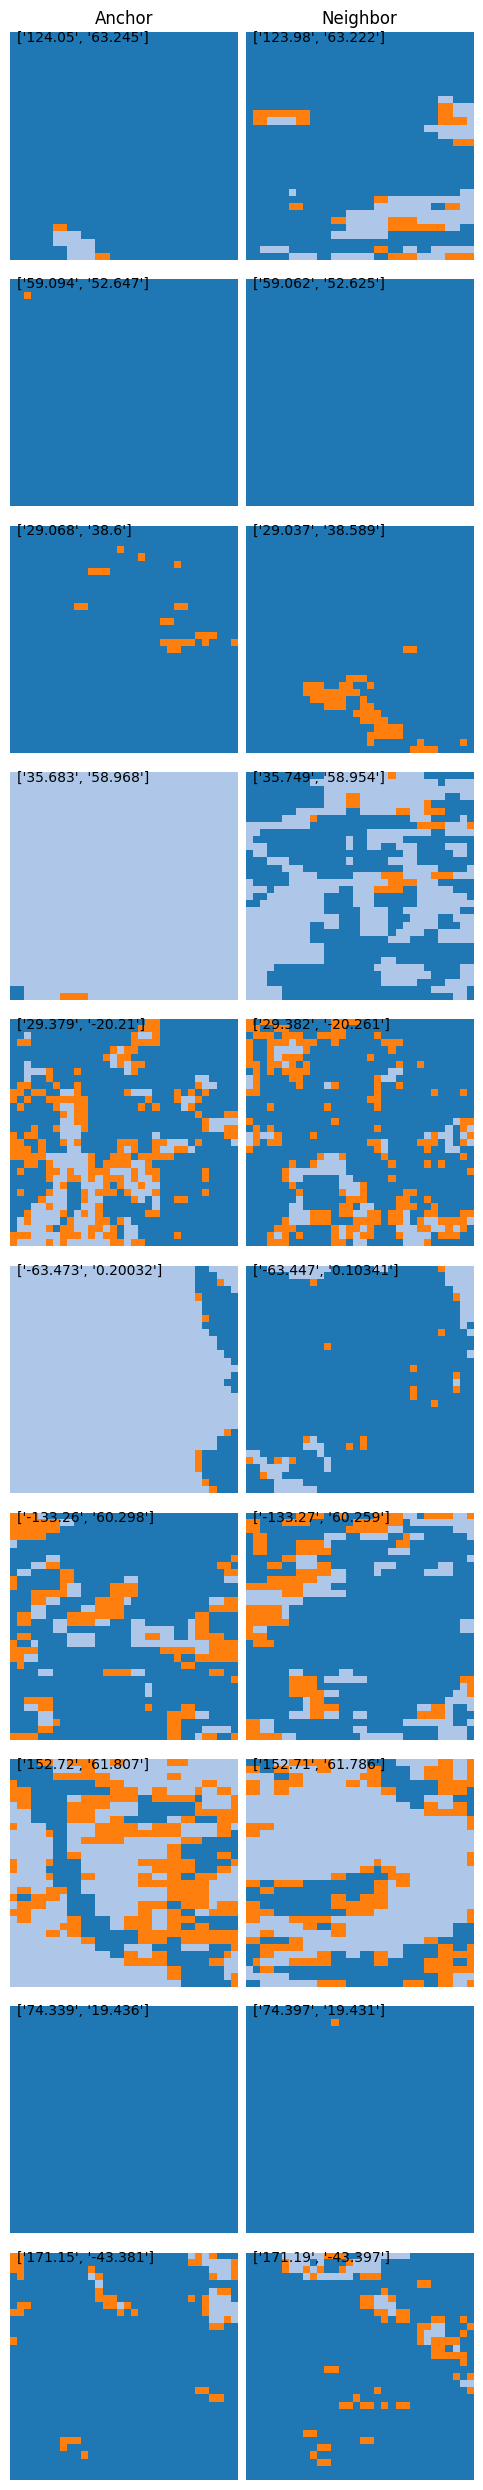

In [5]:
n_shown = 10
fig, axes = plt.subplots(n_shown, 2, figsize=(5, 2.5*n_shown))
for i in range(n_shown):
    axes[i, 0].imshow(patches_array[i, ..., 0].squeeze(), cmap='tab20', vmin=0, vmax=200)
    axes[i, 1].imshow(patches_array[i, ..., 1].squeeze(), cmap='tab20', vmin=0, vmax=200)

    axes[i, 0].text(0.5, 0.8,[f"{x:.5}" for x in all_pts[i]], color='k')
    axes[i, 1].text(0.5, 0.8,[f"{x:.5}" for x in all_pt_nbrs[i]], color='k')

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

axes[0, 0].set_title('Anchor')
axes[0, 1].set_title('Neighbor')    
plt.tight_layout()